In [1]:
%reload_ext autoreload
%autoreload 2

In [49]:
from utils import FocalLoss

In [2]:
import fastai
from fastai.vision import *
import pretrainedmodels

In [3]:

from imbalanced_sampler import ImbalancedDatasetSampler

In [4]:
path = Path('.')

In [5]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [6]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [7]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [8]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [9]:
(df.has_oilpalm==1).sum()

942

In [10]:
from fastai.torch_core import flatten_model

def inceptionv4(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['inceptionv4'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [11]:
def get_data(df, size=128, bs=64, pct=0.2, seed=2019):
    data = (ImageItemList.from_df(df, path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names)
           .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size))
    
    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], func=np.log)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl=train_dl, valid_dl=val_dl, test_dl=test_dl).normalize(imagenet_stats)

In [12]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, mixup=True, fp16=True):
    learn = create_cnn(data, 
                       inceptionv4,
                       pretrained=True,
                       loss_func=FocalLoss(gamma=2),
                       metrics=[accuracy],
                       cut=-2, 
                       split_on=lambda m: (m[0][11], m[1]))
    if mixup: learn.mixup()
    if fp16: return learn.to_fp16()
    else: return learn

In [13]:
data = get_data(df, 256, 64)

In [14]:
learn = get_learner(data, mixup=True)

In [15]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

Group 1: ['BasicConv2d', 'BasicConv2d', 'BasicConv2d', 'Mixed_3a', 'Mixed_4a', 'Mixed_5a', 'Inception_A', 'Inception_A', 'Inception_A', 'Inception_A', 'Reduction_A']
Group 2: ['Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Reduction_B', 'Inception_C', 'Inception_C', 'Inception_C']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


In [16]:
learn.loss_func

MixUpLoss(
  (crit): FocalLoss()
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


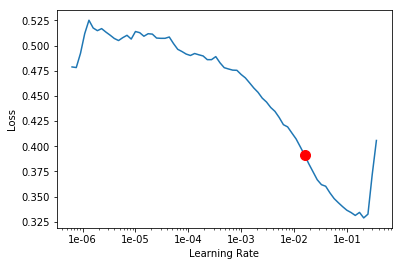

In [41]:
learn.lr_find(); learn.recorder.plot()

In [42]:
lr = 1e-2

256

In [ ]:
learn.fit_one_cycle(6, lr)
learn.save('256')

epoch,train_loss,valid_loss,accuracy
1,0.065903,0.066416,0.971785
2,0.053722,0.032082,0.982940
3,0.042436,0.017805,0.988189
4,0.037053,0.026105,0.985564
5,0.034615,0.013196,0.991142


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


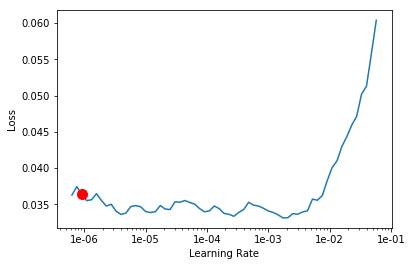

In [44]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [45]:
learn.fit_one_cycle(6, slice(1e-4,1e-3))
learn.save('256u')

epoch,train_loss,valid_loss,accuracy
1,0.035090,0.012387,0.990157
2,0.038402,0.015710,0.986549
3,0.035841,0.016272,0.986549
4,0.033625,0.016627,0.987861
5,0.032300,0.013036,0.990486
6,0.031678,0.012552,0.991798


In [17]:
learn.load('256u');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


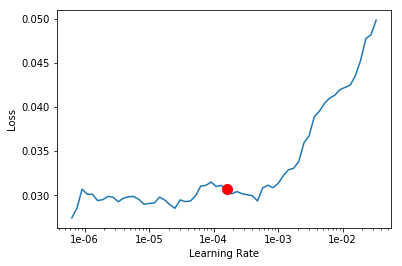

In [18]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.031202,0.012898,0.990157
2,0.029260,0.012989,0.991142
3,0.030608,0.013446,0.992126
4,0.028296,0.012699,0.991470
5,0.029101,0.012849,0.991142
6,0.029188,0.013160,0.990157
7,0.027241,0.011864,0.993766
8,0.029577,0.013065,0.991470
9,0.029893,0.014182,0.990157
10,0.031497,0.013278,0.991142


Results

In [73]:
learn = get_learner(data, mixup=False)
learn.load('256u');

[(1, 0, 19), (0, 1, 6)]

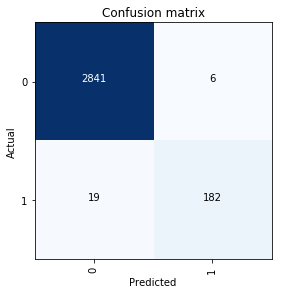

In [74]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()

In [75]:
interp.top_losses(10)

(tensor([1.2399, 1.1326, 1.1027, 0.9937, 0.7246, 0.7118, 0.6689, 0.5742, 0.5042,
         0.4873]),
 tensor([2032,  605, 1184,  276,  699, 2626, 1828, 2943, 1493, 1889]))

In [60]:
def get_hard(learn):
    interp_val = ClassificationInterpretation.from_learner(learn)
    interp_train = ClassificationInterpretation.from_learner(learn, DatasetType.Train)
    fn, fp = interp_val.most_confused()
    n1 = fn[2]+fp[2]
    fn, fp = interp_train.most_confused()
    n2 = fn[2]+fp[2]
    print(f'Hard images count : {n1+n2}')
    losses, idxs_val = interp_val.top_losses(int(n1))
    losses, idxs_train = interp_train.top_losses(int(n2))

    hard_images_val = data.valid_ds.items[idxs_val]
    hard_images_train = data.train_ds.items[idxs_train]

    hard_images_names = [f[-17:] for f in hard_images_train] + [f[-17:] for f in hard_images_val]; hard_images_names[0:3]
    return hard_images_names

In [61]:
hard_images_names = get_hard(learn)

df2 = df.set_index('image_id')
df2 = df2.loc[hard_images_names]
df2.reset_index().to_csv('hard_examples.csv', index=False)

Hard images count : 103


In [62]:
df2 = pd.read_csv('hard_examples.csv')

In [63]:
data = get_data(df2, 256, 8, 0.1)

In [64]:
learn = get_learner(data, mixup=False)

In [65]:
learn.load('256u');
learn.fit_one_cycle(10, slice(1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.129574,0.165983,0.800000
2,0.166745,0.178967,0.800000
3,0.140419,0.182837,0.800000
4,0.156431,0.174995,0.800000
5,0.144823,0.176103,0.800000
6,0.157541,0.171366,0.800000
7,0.165861,0.164493,0.800000
8,0.183427,0.182219,0.800000
9,0.179052,0.194740,0.800000
10,0.182461,0.186656,0.800000


In [67]:
learn.save('hard')

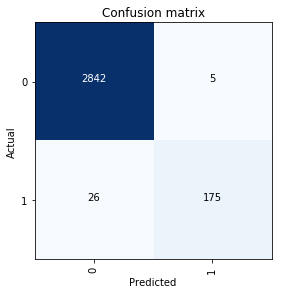

In [68]:
data = get_data(df, 256, 64)
learn = get_learner(data, mixup=False)
learn.load('hard')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

RuntimeError: expected scalar type Half but found Float

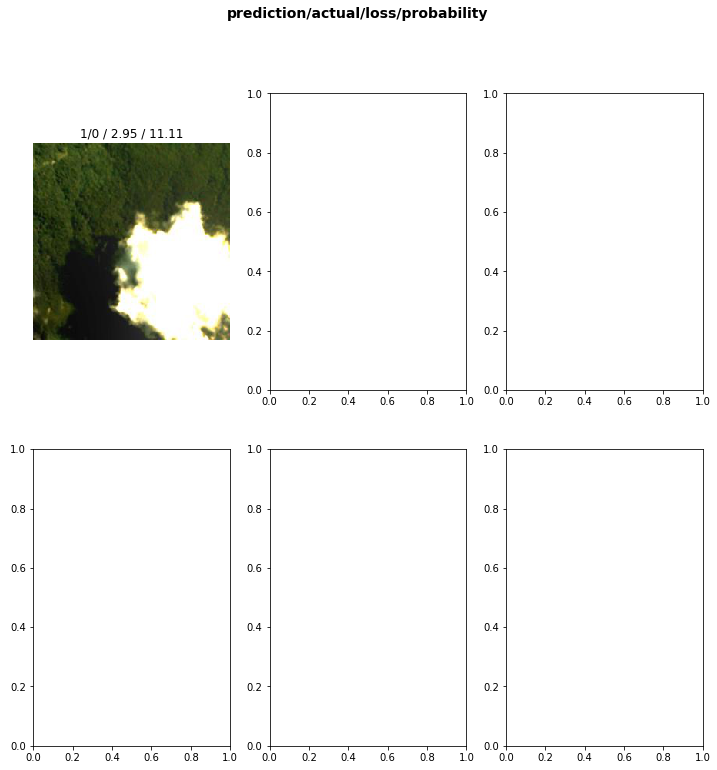

In [70]:
interp.plot_top_losses(5)

## Sub file

In [86]:
p,t = learn.get_preds(DatasetType.Test)

In [87]:
preds = to_np(p[:,1]);preds.shape

(6534,)

In [88]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [89]:
ids.shape

(6534,)

In [90]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [91]:
sub.to_csv('sub_inception.csv', index=False)